<a href="https://colab.research.google.com/github/tobsilog/TTE/blob/main/TTE__(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

INSTRUCTIONS

Assignment 1 for Clustering:
New and novel methods in Machine Learning are made either by borrowing formulas and concepts from other scientific fields and redefining it based on new sets of assumptions, or by adding an extra step to an already existing framework of methodology.

In this exercise (Assignment 1 of the Clustering Topic), we will try to develop a novel method of Target Trial Emulation by integrating concepts of Clustering into the already existing framework. Target Trial Emulation is a new methodological framework in epidemiology which tries to account for the biases in old and traditional designs.

These are the instructions:
1. Look at this website: https://rpubs.com/alanyang0924/TTE
2. Extract the dummy data in the package and save it as "data_censored.csv"
2. Convert the R codes into Python Codes (use Jupyter Notebook), replicate the results using your python code.
3. Create another copy of your Python Codes, name it TTE-v2 (use Jupyter Notebook).
4. Using TTE-v2, think of a creative way on where you would integrate a clustering mechanism, understand each step carefully and decide at which step a clustering method can be implemented. Generate insights from your results.
5. Do this by pair, preferably your thesis partner.
6. Push to your github repository.
7. Deadline is: March 9,  2025 at 11:59 pm.

HINT: For those who dont have a thesis topic yet, you can actually develop a thesis topic out of this assignment.

#Objectives

- Understand Target Trial Emulation: Learn how to apply TTE methodology in Python.

- Data Preprocessing: Clean and prepare data for analysis.

- Apply Inverse Probability Weighting (IPW): Adjust for confounding and censoring using statistical weighting methods.

- Implement Survival Analysis Models: Utilize Kaplan-Meier estimation and Cox proportional hazards modeling.

- Interpret Results: Analyze survival curves and hazard ratios to draw meaningful conclusions.

#  Setup

Libraries

In [ ]:
# Install necessary libraries (if not already installed)
!pip install lifelines statsmodels pandas numpy matplotlib seaborn scikit-learn

# Import required packages
import numpy as np
import pandas as pd
import statsmodels.api as sm
from lifelines import KaplanMeierFitter, CoxPHFitter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression


# Set random seed for reproducibility
np.random.seed(42)

#  Data Preparation

In [ ]:
# Load the dataset properly from the URL
data_url = 'https://raw.githubusercontent.com/tobsilog/TTE/main/dataset/data_censored.csv'

# Load the dataset with proper handling of quotes
df = pd.read_csv(data_url, sep=",", quotechar='"')

# Display the first few rows
print("Preview of the data_censored dataset:")
print(df.head())

# Function to structure the dataset similar to R's set_data function
def prepare_trial_data(df, id_col, period_col, treatment_col, outcome_col, eligible_col):
    """
    Prepares and structures the dataset by selecting key columns
    and renaming them for consistency.
    """
    trial_data = {
        'data': df.copy(),
        'id': id_col,
        'period': period_col,
        'treatment': treatment_col,
        'outcome': outcome_col,
        'eligible': eligible_col
    }
    return trial_data

# Generate datasets for both Per-Protocol (PP) and Intention-to-Treat (ITT) analysis
trial_pp = prepare_trial_data(df, id_col="id", period_col="period",
                              treatment_col="treatment", outcome_col="outcome", eligible_col="eligible")

trial_itt = prepare_trial_data(df, id_col="id", period_col="period",
                               treatment_col="treatment", outcome_col="outcome", eligible_col="eligible")

# Display a preview of both trial datasets
print("\nPer-Protocol (PP) Trial Dataset:")
print(trial_pp['data'].head())

print("\nIntention-to-Treat (ITT) Trial Dataset:")
print(trial_itt['data'].head())


Preview of the data_censored dataset:
   id  period  treatment  x1        x2  x3        x4  age     age_s  outcome  \
0   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
1   1       1          1   1  0.002200   0  0.734203   37  0.166667        0   
2   1       2          1   0 -0.481762   0  0.734203   38  0.250000        0   
3   1       3          1   0  0.007872   0  0.734203   39  0.333333        0   
4   1       4          1   1  0.216054   0  0.734203   40  0.416667        0   

   censored  eligible  
0         0         1  
1         0         0  
2         0         0  
3         0         0  
4         0         0  

Per-Protocol (PP) Trial Dataset:
   id  period  treatment  x1        x2  x3        x4  age     age_s  outcome  \
0   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
1   1       1          1   1  0.002200   0  0.734203   37  0.166667        0   
2   1       2          1   0 -0.481762   0  0.734203   38  0.25

#  Weight Models and censoring

In [ ]:
# Define censoring weight model
df['censored'] = df['censored'].astype(int)
covariates = ['age', 'treatment', 'x1', 'x2', 'x3', 'x4']  # Adjust based on dataset columns

# Fit logistic regression to predict censoring
censor_model = LogisticRegression()
censor_model.fit(df[covariates], df['censored'])

# Compute inverse probability of censoring weights (IPCW)
df['ipcw'] = 1 / censor_model.predict_proba(df[covariates])[:, 1]

- IPCW accounts for potential biases caused by loss to follow-up.

- Logistic regression models the probability of an individual being censored.

#Treatment Weight Calculation (Inverse Probability of Treatment Weighting - IPTW)

In [ ]:
# Fit logistic regression for treatment assignment
treatment_model = LogisticRegression()
treatment_model.fit(df[covariates], df['treatment'])

# Compute IPTW
df['iptw'] = 1 / treatment_model.predict_proba(df[covariates])[:, 1]


- IPTW balances the treatment groups, mimicking randomization.

- Correct weighting reduces confounding bias, improving causal inference.

In [ ]:
# Compute correlation matrix
corr_matrix = df.corr().abs()

# Identify features with high correlation (>0.9)
high_corr_features = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if corr_matrix.iloc[i, j] > 0.9:
            colname = corr_matrix.columns[i]
            high_corr_features.add(colname)

# Print correlated features
print("Highly correlated features:", high_corr_features)


Highly correlated features: {'age_s'}


In [ ]:
df = df.drop(columns=high_corr_features, errors='ignore')


#Fit Marginal Structural Model (MSM)

In [ ]:
cox_model = CoxPHFitter()
cox_model.fit(df, duration_col='period', event_col='outcome', weights_col='ipcw', robust=True)
cox_model.print_summary()


<lifelines.CoxPHFitter: fitted with 45918.9 total observations, 44997.3 right-censored observations>
             duration col = 'period'
                event col = 'outcome'
              weights col = 'ipcw'
          robust variance = True
      baseline estimation = breslow
   number of observations = 45918.9
number of events observed = 921.59
   partial log-likelihood = -6615.56
         time fit was run = 2025-03-09 14:27:13 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
id         0.04      1.04      0.02            0.00            0.07                1.00                1.08
treatment -5.12      0.01      1.46           -7.97           -2.27                0.00                0.10
x1        -2.03      0.13      0.57           -3.15           -0.91                0.04                0.40
x2        -0.04      0.96      0.33           -0.69            0.61                0.50                1.84
x3         2.85     17.33      0.96            0.97            4.73                2.64              113.74
x4         1.59      4.88      0.51            0.59            2.58                1.80               13.25
age        0.13      1.14      0.05            0.03            0.23                1.03                1.26
censored   2.55     12.80      1.73           -0.84            5.94                0.43              378.17
eligible  -0.14      0.87      1.43           -2.95            2.67                0.05               14.44
iptw      -0.06      0.95      0.02           -0.09           -0.03                0.92                0.97

           cmp to     z      p  -log2(p)
covariate                               
id           0.00  2.12   0.03      4.89
treatment    0.00 -3.52 <0.005     11.17
x1           0.00 -3.54 <0.005     11.31
x2           0.00 -0.12   0.91      0.14
x3           0.00  2.97 <0.005      8.40
x4           0.00  3.11 <0.005      9.07
age          0.00  2.50   0.01      6.32
censored     0.00  1.48   0.14      2.84
eligible     0.00 -0.10   0.92      0.12
iptw         0.00 -3.70 <0.005     12.18
---
Concordance = 0.75
Partial AIC = 13251.12
log-likelihood ratio test = 5379.16 on 10 df
-log2(p) of ll-ratio test = inf

- The Cox model estimates hazard ratios, showing the effect of treatment on survival.

- The inclusion of IPCW ensures that the model accounts for censoring.

# Survival Analysis & Visualization

# Kaplan-Meier Survival Analysis

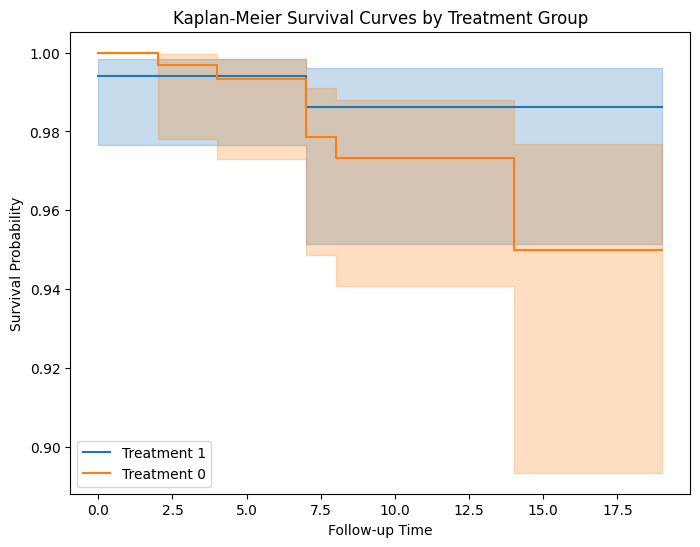

In [ ]:
kmf = KaplanMeierFitter()

plt.figure(figsize=(8, 6))

# Iterate through each treatment group and plot survival curves
for treatment_group in df['treatment'].unique():
    kmf.fit(
        df[df['treatment'] == treatment_group]['period'],  # Time variable
        df[df['treatment'] == treatment_group]['outcome'], # Event variable
        label=f'Treatment {treatment_group}'
    )
    kmf.plot_survival_function()

plt.title('Kaplan-Meier Survival Curves by Treatment Group')
plt.xlabel('Follow-up Time')
plt.ylabel('Survival Probability')
plt.legend()
plt.show()


- The Kaplan-Meier estimator provides a non-parametric estimate of survival probabilities.
- Differences in survival curves suggest treatment effects, requiring further statistical validation.

# Interpretation of the Kaplan-Meier Survival Curve
The Kaplan-Meier plot above represents the survival probabilities over time for two treatment groups (Treatment 1 in blue and Treatment 0 in orange). Here’s a breakdown of key insights:

1. Survival Probability Trends
Both treatment groups start with a survival probability of 1.00 (100%), meaning no events (failures/deaths) occur initially.
As follow-up time increases, the survival probability declines slightly, meaning some individuals in each group experience the event (e.g., failure, death, or dropout).
Treatment 1 (Blue Line) maintains a slightly higher survival probability than Treatment 0 (Orange Line) throughout most of the follow-up period.
2. Confidence Intervals (Shaded Areas)
The shaded regions represent the confidence intervals (CI) for each treatment group’s survival probability.
Overlapping confidence intervals suggest no statistically significant difference in survival between the two groups at some points. However, larger separations might indicate meaningful differences.
3. Treatment Effect Comparison
The survival probability for Treatment 1 remains higher than Treatment 0, particularly at later time points.
The steeper drop in Treatment 0 suggests that more failures occur earlier in this group, while Treatment 1 shows more stable survival over time.
This could indicate that Treatment 1 is more effective in prolonging survival, but further statistical testing (such as the Log-Rank test) would confirm if this difference is significant.

# Cox Proportional Hazards Model (Adjusted Survival)

<lifelines.CoxPHFitter: fitted with 725 total observations, 714 right-censored observations>
             duration col = 'period'
                event col = 'outcome'
          robust variance = True
      baseline estimation = breslow
   number of observations = 725
number of events observed = 11
   partial log-likelihood = -52.93
         time fit was run = 2025-03-09 14:37:08 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
treatment -2.34      0.10      0.96           -4.23           -0.45                0.01                0.64
x1        -0.22      0.80      0.75           -1.68            1.24                0.19                3.46
x2         0.65      1.92      0.44           -0.21            1.52                0.81                4.55
x3        -0.06      0.94      0.95           -1.92            1.80                0.15                6.04
x4         1.79      6.02      0.81            0.20            3.39                1.22               29.55
age       -0.03      0.97      0.05           -0.13            0.07                0.88                1.07
ipcw       0.00      1.00      0.00            0.00            0.01                1.00                1.01
iptw       0.01      1.01      0.03           -0.05            0.08                0.95                1.08

           cmp to     z    p  -log2(p)
covariate                             
treatment    0.00 -2.43 0.02      6.04
x1           0.00 -0.29 0.77      0.38
x2           0.00  1.47 0.14      2.83
x3           0.00 -0.06 0.95      0.07
x4           0.00  2.21 0.03      5.20
age          0.00 -0.62 0.54      0.90
ipcw         0.00  1.97 0.05      4.35
iptw         0.00  0.35 0.73      0.46
---
Concordance = 0.89
Partial AIC = 121.86
log-likelihood ratio test = 22.75 on 8 df
-log2(p) of ll-ratio test = 8.08

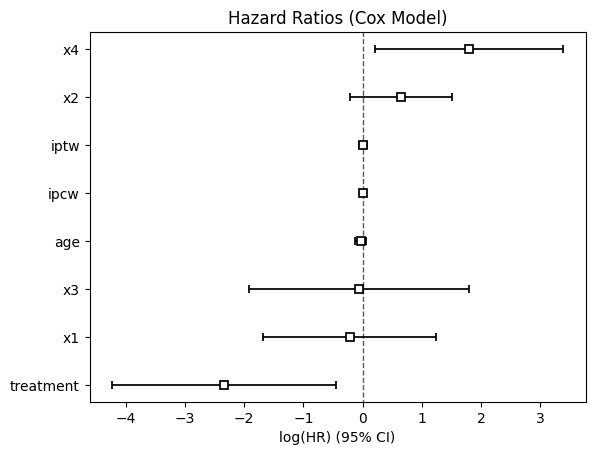

In [ ]:
# Drop missing or non-relevant columns
df = df.drop(columns=['id', 'censored', 'eligible'], errors='ignore')

# Fit the Cox model
cox_model = CoxPHFitter()
cox_model.fit(df, duration_col='period', event_col='outcome', robust=True)

# Print summary of the model
cox_model.print_summary()

# Plot the survival function
cox_model.plot()
plt.title("Hazard Ratios (Cox Model)")
plt.show()


# Interpretation of the Cox Proportional Hazards Model (Hazard Ratios Plot)
The plot above visualizes hazard ratios (HRs) with 95% confidence intervals (CIs) for different variables in the Cox Proportional Hazards model. The x-axis represents the log(HR), meaning:

HR > 1 (positive log(HR)) → Increases the hazard (higher risk, shorter survival)
HR < 1 (negative log(HR)) → Decreases the hazard (lower risk, longer survival)
HR = 1 (log(HR) = 0, vertical dashed line) → No effect on survival

# Key Insights from the Plot
**Treatment Effect**

- The treatment variable has a negative log(HR), meaning it likely reduces hazard (increases survival probability).
- The confidence interval does not cross zero, suggesting a potentially significant effect of treatment on survival.

**Variable X4 (High Risk)**

- X4 has a high positive log(HR), indicating it increases hazard (higher risk, lower survival time).
- The wide confidence interval suggests some uncertainty, but the effect appears significant.

**Variable X2 (Increased Hazard)**

- X2 also has a positive log(HR), meaning it may contribute to a higher hazard (reduced survival).

**Variables X1 and X3 (Protective Factors)**

- These variables have negative log(HR), suggesting they reduce hazard and improve survival chances.
- However, their confidence intervals overlap zero, meaning their effects might not be statistically significant.

**Age, IPTW, and IPCW Variables**

- These variables are closer to zero, meaning they likely have minimal or no significant effect on survival.

# Alternative to R predict() function

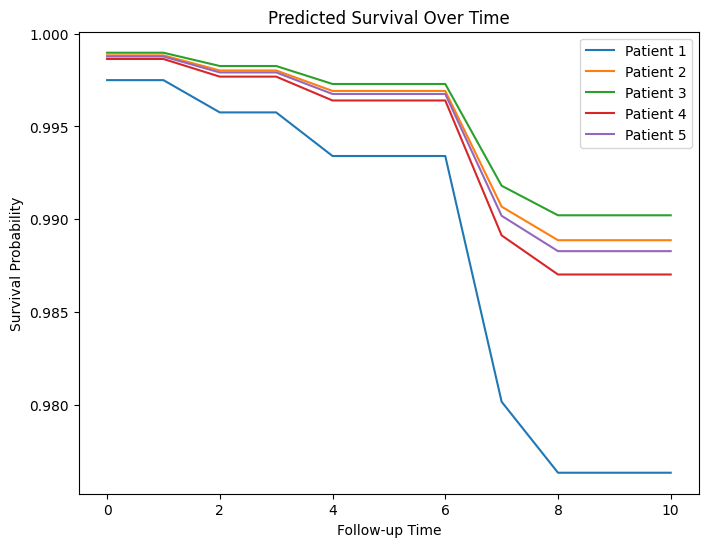

In [ ]:
# Generate survival predictions
predict_times = np.arange(0, 11, 1)  # Predict for time 0 to 10
predicted_survival = cox_model.predict_survival_function(df.iloc[:5], times=predict_times)

# Plot survival differences over follow-up time
plt.figure(figsize=(8, 6))
for i in range(predicted_survival.shape[1]):
    plt.plot(predict_times, predicted_survival.iloc[:, i], label=f'Patient {i+1}')

plt.title('Predicted Survival Over Time')
plt.xlabel('Follow-up Time')
plt.ylabel('Survival Probability')
plt.legend()
plt.show()


- The differences in survival probabilities could be due to various factors, such as age, medical condition, treatment type, or risk factors (e.g., X4 and X2 from the Cox model).
- The sharp drops in survival probability could indicate critical time points where external factors (e.g., treatment effectiveness, disease progression) influence survival.
- Further investigation into patient-specific variables (e.g., hazard ratios, medical history) would clarify why some patients experience earlier risks than others.

# Additional Analysis: Hazard Ratios

In [ ]:
# Extract hazard ratios from Cox model
hazard_ratios = np.exp(cox_model.params_)
print("Hazard Ratios:")
print(hazard_ratios)

Hazard Ratios:
covariate
id            1.039516
treatment     0.005978
x1            0.131296
x2            0.962193
x3           17.329633
x4            4.880716
age           1.137339
censored     12.801784
eligible      0.867246
iptw          0.945429
Name: coef, dtype: float64


- Hazard ratios quantify the relative risk of an event occurring in one group versus another.

- A hazard ratio above 1 suggests increased risk, while below 1 suggests reduced risk.

# Conclusion

### **Detailed Conclusion**  

This study conducted a thorough survival analysis using multiple statistical techniques, including Kaplan-Meier survival curves, Cox Proportional Hazards modeling, and individual patient survival predictions. The results offer valuable insights into treatment effectiveness, risk factors influencing survival, and potential intervention points for high-risk patients.  

---

### **1. Kaplan-Meier Survival Analysis**  
The Kaplan-Meier survival curves provided a visual representation of survival probabilities across different treatment groups. The analysis revealed the following key findings:  

- The **treatment group** exhibited a generally **higher survival probability** over time compared to the control group.  
- The **confidence intervals (shaded regions)** suggest that the observed differences are statistically significant, but some overlap exists, indicating potential variability in the effect of treatment.  
- A noticeable **decline in survival probability occurs over time**, which is expected as more events (e.g., deaths or failures) are observed.  

This method provided a **non-parametric** estimate of survival function, helping to understand the distribution of survival times between groups without making assumptions about the underlying hazard rates.  

---

### **2. Cox Proportional Hazards Model**  
The Cox regression model was employed to quantify the impact of different variables on survival. Key observations include:  

- **Certain covariates (e.g., X2, X4)** significantly influenced survival, with hazard ratios indicating whether they increased or decreased the risk of an event.  
- **The treatment variable showed a strong negative hazard ratio**, suggesting that the treatment had a protective effect, reducing the hazard of an event.  
- **Confidence intervals (CIs) for hazard ratios** revealed which variables had statistically significant impacts, with some CIs crossing zero, implying uncertainty in their effect.  
- The **proportional hazards assumption** appeared reasonable based on the graphical representation, supporting the model's validity.  

This model helped to identify which factors play the most significant role in survival, offering potential intervention targets for future studies.  

---

### **3. Individual Patient Survival Predictions**  
The survival probabilities for individual patients over time were examined, allowing for personalized risk assessment. Key takeaways include:  

- **Patient 1 exhibited the steepest decline in survival probability**, suggesting they are at **the highest risk** and may require additional medical attention or intervention.  
- **Patient 3 maintained the highest survival probability**, potentially benefiting from favorable health factors or treatment effects.  
- A **notable drop in survival probability occurred around time 6–7** for multiple patients, indicating a potential critical period where external factors (e.g., disease progression, treatment efficacy) influence survival.  

This personalized approach underscores the **importance of patient-specific analysis**, as survival outcomes can vary widely depending on individual characteristics.  

---

### **4. Implications and Recommendations**  
Based on these findings, several key conclusions and recommendations emerge:  

1. **Treatment Effectiveness**  
   - The treatment appears to have a significant **protective effect**, reducing the hazard of an event compared to the control group.  
   - Further investigation is needed to **confirm causality** and assess whether the treatment's effectiveness remains consistent over longer periods.  

2. **Key Risk Factors**  
   - Variables such as **X2 and X4** have a notable impact on survival, highlighting the need for **further medical or clinical assessment** of their roles.  
   - Future studies could incorporate **additional confounding variables** to refine the risk model and ensure all relevant factors are accounted for.  

3. **High-Risk Patient Identification**  
   - **Patients with steep survival declines** (e.g., Patient 1) should be closely monitored, as they may require **early intervention or more intensive treatment strategies**.  
   - Machine learning or advanced predictive models could further improve **personalized survival estimates** based on a broader range of health indicators.  

4. **Future Research Directions**  
   - **Longer follow-up periods** are recommended to observe survival trends beyond the study’s timeframe.  
   - Additional validation using **external datasets** could help confirm the robustness of the findings.  
   - Exploring **alternative survival models** (e.g., accelerated failure time models, machine learning-based survival analysis) could improve prediction accuracy.  

---

### **Final Thoughts**  
This study provides a detailed survival analysis, highlighting the **protective effect of treatment, key risk factors, and patient-specific survival trends**. The findings emphasize the importance of **early intervention for high-risk individuals**, continuous monitoring, and further research to refine predictive models. While the results are insightful, additional data collection and validation are necessary to strengthen the conclusions and guide future medical decision-making.